## Laden und Anwenden eines NN mit Tensorflow/Keras

Die verwendet Beispielbild präsentieren bereits nur einen Bildausschnitt und werden in DEMO_TrainingNN.ipynb erstellt.
Siehe auch `/data/images/`

In [1]:
import numpy as np
import matplotlib.pylab as plt
#import cv2

### Einlesen von Beispielbildern und Lenkwinkeln

In [6]:
# Erfassen der Namen der Dateien mit Beispielbildern
from os import listdir
from os.path import isfile, join

picpath = "./data/images/"
imgsfiles = [picpath+f for f in listdir(picpath) if isfile(join(picpath, f))]
imgsfiles

['./data/images/image_10_angle_103.jpg',
 './data/images/image_100_angle_78.jpg',
 './data/images/image_1_angle_78.jpg']

In [7]:
angles_true = [int(filename.split('_')[-1][:-4]) for filename in imgsfiles]
angles_true

[103, 78, 78]

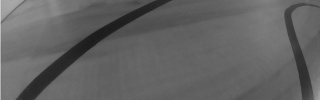

In [8]:
# Einlesen eines Bildes mit PIL (Python Image Library)
from PIL import Image
example_image = Image.open(imgsfiles[0])
example_image

In [9]:
# Kontrolle der Shape
np.array(example_image).shape

(100, 320)

In [10]:
# Einlesen aller Bilder mit PIL
imgs = [np.array(Image.open(img)) for img in imgsfiles]
imgs = np.array(imgs)
imgs.shape

(3, 100, 320)

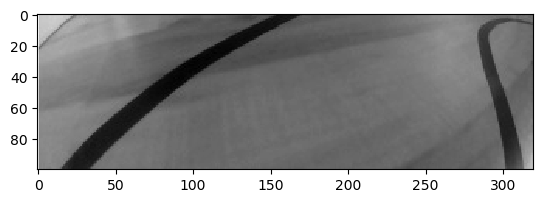

In [11]:
plt.imshow(imgs[0],cmap="gray")

In [12]:
# Alternatives Lesen der Beispielbilder mit OpenCV
# Bilder werden als Farbbilder gelesen, aber als B/W-Bild benötigt

#imgs2 = [cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2GRAY) for i in imgsfiles]
#imgs2 = np.array(imgs2)

#plt.imshow(imgs2[0],cmap="gray")

### Die Beispielbilder müssen in das vom Keras-Modell erwartet Format gebracht werden.

- Shape (Anzahl der Bilder, Höhe, Breite, Farbkanäle)

In [12]:
# Reshapen
n,h,w = imgs.shape
imgs = imgs.reshape((n,h,w,1))

In [13]:
imgs.shape

(3, 100, 320, 1)

### Laden des trainierten Keras-Modells

In [14]:
# Prüfen, ob h5py importierbar ist!
# Falls nicht, kanndas laden des Modells fehlschlagen
# sudo apt-get install libhdf5-dev
# https://www.appsloveworld.com/bestanswer/raspberry-pi/1/h5py-import-error-on-libhdf5-serial-so-100?expand_article=1

import h5py#h5py.__version__

In [2]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
model = tf.keras.models.load_model("./gitignore/data/model/DEMO_MODEL.h5")

In [17]:
model(imgs).numpy()

array([[107.926216],
       [ 85.98997 ],
       [ 89.63918 ]], dtype=float32)

In [17]:
angles_pred = model(imgs).numpy().T[0]
angles_pred

array([107.926216,  85.98997 ,  89.63918 ], dtype=float32)

In [18]:
single_img = imgs[:1,:,:,:]

In [19]:
%timeit model(single_img).numpy()

38.3 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Alternative Verwendung des Modells mit Tensorflow-Lite
Das trainierte Modell muss dazu entsprechend convertiert und gespeichert werden. (siehe DEMO_TrainingNN.ipynb)

Der Tensoflow Runtime interpreter muss installiert werden.

`pip install tflite-runtime`

In [1]:
import tflite_runtime.interpreter as tfi

In [ ]:
# Laden des Modells
interpreter = tfi.Interpreter(model_path="./DEMO_MODEL.tflite")

In [1]:
# Einige Info zum Input-Layer
# -> Der Input-Layer hat den Index 0!
# -> Die erwartet Shape ist (1,10,320,1) -> Einzelbild
# -> Der erwartete Datentype ist numpy.float32!
interpreter.get_input_details()

NameError: name 'interpreter' is not defined

In [26]:
# Einige Infos zum Output-Layer - Der Output-Layer hat den Index 37!
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 37,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [52]:
imgs_f32 = imgs.astype(np.float32)

In [28]:
# Einmalige Ausführung stellt Resourcen bereits
interpreter.allocate_tensors()

In [42]:
# Setzen der Werte für den Input-Layer
interpreter.set_tensor(0,imgs_f32[:1,:,:,:])

In [43]:
# Prozessieren des Netzes
interpreter.invoke()

In [44]:
# Abfrage des Output-Layers
interpreter.get_tensor(37)

array([[107.9262]], dtype=float32)

In [70]:
single_img_f32 = imgs_f32[:1,:,:,:]

def mypredict(img):
    interpreter.set_tensor(0,img)
    interpreter.invoke()
    return interpreter.get_tensor(37)[0][0]

In [71]:
mypredict(single_img_f32)

107.9262

In [73]:
%timeit mypredict(single_img_f32)

36 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
angles_pred_lite = [mypredict(imgs_f32[i:1+i]) for i in range(3)]

In [75]:
angles_pred_lite

[107.9262, 85.98996, 89.63917]

In [66]:
angles_pred

array([107.926216,  85.98997 ,  89.63918 ], dtype=float32)